# Implementing a neural network for MNIST with Keras

Open tensorboard with: tensorboard --logdir=logs/

### Setup

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Prepare the data

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
length_flattend = 784

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape of 784 length vector for the fully connected (fc) nn
x_train_fc = x_train.reshape((-1,784))
x_test_fc = x_test.reshape((-1,784))
print("x shape:", x_train_fc.shape)
print(x_train_fc.shape[0], "train samples FC")
print(x_test_fc.shape[0], "test samples FC")

# Make sure images have shape (28, 28, 1) for the CNN
x_train_cnn = np.expand_dims(x_train, -1)
x_test_cnn = np.expand_dims(x_test, -1)
print("x shape:", x_train_cnn.shape)
print(x_train_cnn.shape[0], "train samples CNN")
print(x_test_cnn.shape[0], "test samples CNN")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 0s 0us/step
x shape: (60000, 784)
60000 train samples FC
10000 test samples FC
x shape: (60000, 28, 28, 1)
60000 train samples CNN
10000 test samples CNN


### Build the model

In [5]:
model_fc = keras.Sequential(
    [   layers.Dense(25, activation="relu", input_shape=(length_flattend,)),
        layers.Dense(25, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model_fc.summary()

2022-11-02 07:10:17.277609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10794 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                19625     
                                                                 
 dense_4 (Dense)             (None, 25)                650       
                                                                 
 dense_5 (Dense)             (None, 10)                260       
                                                                 
Total params: 20,535
Trainable params: 20,535
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [6]:
batch_size = 256
epochs = 10
now = datetime.now()

model_fc.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
tensorboard = TensorBoard(log_dir='logs/{}'.format(f"Fully_connected_model_{now.strftime('%Y%m%d-%H:%M:%S')}"))
history = model_fc.fit(x_train_fc, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks = [tensorboard])

Epoch 1/10
211/211 [==============================] - 37s 4ms/step - loss: 0.8561 - accuracy: 0.7550 - val_loss: 0.2843 - val_accuracy: 0.9240
Epoch 2/10
211/211 [==============================] - 1s 3ms/step - loss: 0.2956 - accuracy: 0.9161 - val_loss: 0.2055 - val_accuracy: 0.9433
Epoch 3/10
211/211 [==============================] - 1s 3ms/step - loss: 0.2408 - accuracy: 0.9306 - val_loss: 0.1749 - val_accuracy: 0.9522
Epoch 4/10
211/211 [==============================] - 1s 3ms/step - loss: 0.2126 - accuracy: 0.9380 - val_loss: 0.1620 - val_accuracy: 0.9545
Epoch 5/10
211/211 [==============================] - 1s 3ms/step - loss: 0.1931 - accuracy: 0.9429 - val_loss: 0.1513 - val_accuracy: 0.9572
Epoch 6/10
211/211 [==============================] - 1s 3ms/step - loss: 0.1777 - accurac

### Evaluate the model

In [7]:
score = model_fc.evaluate(x_test_fc, y_test, verbose=0)
print("Fully connected model:")
print("Test loss:", np.round(score[0],4))
print("Test accuracy:", np.round(score[1],4))

Fully connected model:
Test loss: 0.1526
Test accuracy: 0.9551


### Does the model really work?

In [8]:
fc_predicted_test = np.argmax(model_fc.predict(x_test_fc), axis = -1)
compare_fc = np.nonzero(y_test.argmax(axis = 1)!= fc_predicted_test)[0]
print(len(compare_fc))

313/313 [==============================] - 0s 1ms/step
449


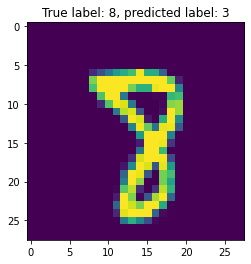

In [9]:
picture_number = compare_fc[101]
plt.figure()
plt.imshow(x_test_fc[picture_number].reshape(28,28))
plt.title(f"True label: {y_test[picture_number].argmax()}, predicted label: {fc_predicted_test[picture_number]}")
plt.show()

### Let's try a different model structure (convolutional neural network)

In [10]:
model_cnn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(54, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(27, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 54)        540       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 54)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 27)        13149     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 27)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 675)               0         
                                                                 
 dense_6 (Dense)             (None, 10)               

In [17]:
batch_size = 256
epochs = 10
now = datetime.now()

model_cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
tensorboard = TensorBoard(log_dir='logs/{}'.format(f"CNN_{now.strftime('%Y%m%d-%H:%M:%S')}"))
history = model_cnn.fit(x_train_cnn, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks = [tensorboard])

Epoch 1/10
422/422 [==============================] - 4s 8ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 0.0406 - val_accuracy: 0.9898
Epoch 2/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.0518 - val_accuracy: 0.9870
Epoch 3/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0567 - val_accuracy: 0.9857
Epoch 4/10
400/422 [===========================>..] - ETA: 0s - loss: 0.0132 - accuracy: 0.9955

KeyboardInterrupt: 

In [12]:
score = model_cnn.evaluate(x_test_cnn, y_test, verbose=0)
print("CNN model:")
print("Test loss:", np.round(score[0],4))
print("Test accuracy:", np.round(score[1],4))

CNN model:
Test loss: 0.0471
Test accuracy: 0.9851


In [13]:
cnn_predicted_test = np.argmax(model_cnn.predict(x_test_cnn), axis = -1)
compare_cnn = np.nonzero(y_test.argmax(axis = 1)!= cnn_predicted_test)[0]
print(len(compare_cnn))

313/313 [==============================] - 1s 2ms/step
149


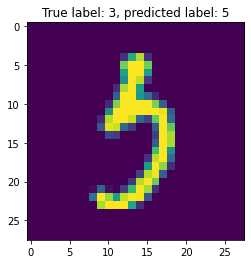

In [14]:
picture_number = compare_cnn[101]
plt.figure()
plt.imshow(x_test_cnn[picture_number].reshape(28,28))
plt.title(f"True label: {y_test[picture_number].argmax()}, predicted label: {cnn_predicted_test[picture_number]}")
plt.show()